In [5]:
import sys
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pickle

from sqlalchemy import create_engine

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier


def load_data(database_filepath):
   
    table_name = "disaster_respone"
    
    engine = create_engine('sqlite:///' + database_filepath)
    
    df = pd.read_sql_table(table_name, con=engine)
    
    df = df.iloc[:200]
    
    X = df["message"].values
    
    y = df.iloc[:,5:]
    
    category_names =  y.columns

    return X, y, category_names

class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            try:
                first_word, first_tag = pos_tags[0]
                if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                    return True
            except:
                return False
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)


def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    
    #remove all special characters
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


def build_model():
    '''
    build the GridSearchCV Model via usage of a pipeline and defines the parameters for the moden 
            Parameters:
                    None
            Returns:
                    cv(obj): GridSearchCV model 
    '''
    rfc = RandomForestClassifier()
    classifier = MultiOutputClassifier(rfc)
    
    # define Pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', classifier)])

    # define parameters
    parameters = {
        'clf__estimator__min_samples_leaf': [50],
        'clf__estimator__min_samples_leaf': [2],
    }

    cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=4)

    return cv

    


def evaluate_model(model, X_test, Y_test, category_names):
    y_pred = model.predict(X_test)
    print(classification_report(Y_test, y_pred, target_names=category_names))


def save_model(model, model_filepath):
    pickle.dump(model, open(model_filepath, 'wb'))


database_filepath, model_filepath =  "../Data/DisasterResponse.db", "classifier.pkl"
print('Loading data...\n    DATABASE: {}'.format(database_filepath))
X, Y, category_names = load_data(database_filepath)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# print('Building model...')
# model = build_model()

# print('Training model...')
# model.fit(X_train, Y_train)

# print('Evaluating model...')
# evaluate_model(model, X_test, Y_test, category_names)

# print('Saving model...\n    MODEL: {}'.format(model_filepath))
# save_model(model, model_filepath)

print('Trained model saved!')





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Loading data...
    DATABASE: ../Data/DisasterResponse.db
Trained model saved!


In [2]:
 pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', RandomForestClassifier())
    ])

In [9]:
try:
    a = 0
except:
    True

In [18]:
# evaluate_model(model, X_test, Y_test, category_names)

In [20]:
Y_test.shape

(40, 36)

In [25]:
table_name = "disaster_respone"
    
engine = create_engine('sqlite:///' + database_filepath)

df = pd.read_sql_table(table_name, con=engine)

In [27]:
df["message_len"] = df["message"].str.len()

In [41]:
def message_length_category(length):
    if length <= 50:
        return '<= 50'
    elif length <= 100:
        return '<= 100'
    elif length <= 150:
        return '<= 150'
    else:
        return '> 150'

In [81]:
message_length_categorie_list = df.message_len.apply(message_length_category)

In [82]:
categories = df["message_length_category"].unique()

In [107]:
values =  df.groupby("message_length_category").count().iloc[:, :1].values

In [84]:
df.groupby("message_length_category").count()

,index,id,message,original,genre,related,request,offer,aid_related,medical_help,...,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,message_len
message_length_category,,,,,,,,,,,,,,,,,,,,,
<= 100,7069,7069,7069,4410,7069,7069,7069,7069,7069,7069,...,7069,7069,7069,7069,7069,7069,7069,7069,7069,7069
<= 150,6805,6805,6805,1969,6805,6805,6805,6805,6805,6805,...,6805,6805,6805,6805,6805,6805,6805,6805,6805,6805
<= 50,2817,2817,2817,2417,2817,2817,2817,2817,2817,2817,...,2817,2817,2817,2817,2817,2817,2817,2817,2817,2817
> 150,9332,9332,9332,1241,9332,9332,9332,9332,9332,9332,...,9332,9332,9332,9332,9332,9332,9332,9332,9332,9332


In [74]:
categories.unique()

array(['<= 100', '<= 50', '<= 150', '> 150'], dtype=object)

In [86]:
values

array([[7069],
       [6805],
       [2817],
       [9332]], dtype=int64)

In [87]:
import seaborn as sns

<AxesSubplot:ylabel='index'>

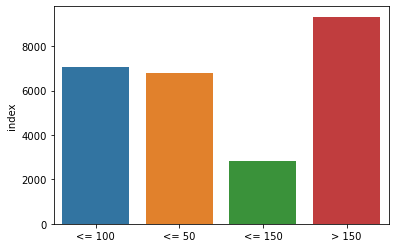

In [117]:
sns.barplot(x=categories, y=values)

In [116]:
values =  df.groupby("message_length_category").count().iloc[:, :1]

In [113]:
values = values